In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display


# Transform CSV in programmable JSON

```python
scores: {
    "team_name": {
        "week_name": {
            "problem_name": {
                "person_name: {
                    "attempts": int
                    "top": int, 1 for yes 0 for no
                    "zone": int,  1 for yes 0 for no
                }
            }
        }
    }
}
```

In [2]:
person_scores = {
    "advanced": {},
    "intermediate": {},
    "recreational": {}
}


def read_person_weekly_scores(all_person_scores):
    weekly_scores = {}
    for week, i in enumerate(range(0, len(all_person_scores), 3)):
        raw_scores = all_person_scores[i:i+3]
        weekly_scores[f"week-{week+1}"] = {
            "tops": int(raw_scores[0].strip()),
            "zones": int(raw_scores[1].strip()),
            "attempts": int(raw_scores[2].strip()),
        }
    return weekly_scores


with open("BKBouldering League 2.0 - Overall Individual Scores.csv") as indi_scores_file:
    cat = "advanced"
    for line_num, line in enumerate(indi_scores_file.readlines()):
        if line_num < 3:
            continue
        if "intermediate" in line.lower():
            cat = "intermediate"
        elif "recreational" in line.lower():
            cat = "recreational"
        else:
            cells = line.split(",")
            if cells[0].strip() == "":
                continue
            name = cells[1]
            scores = cells[5:]
            person_scores[cat][name] = read_person_weekly_scores(scores)

In [3]:
aggregate_scores = {}
worst_weeks = {}
for cat in person_scores.keys():
    aggregate_scores[cat] = {}
    worst_weeks[cat] = {}
    for person in person_scores[cat].keys():
        aggregate_scores[cat][person] = {
            "overall": {},
            "adjusted": {}
        }
        weekly_scores = list(person_scores[cat][person].values())
        aggregate_scores[cat][person]["overall"] = {
            "tops": sum(map(lambda s: s["tops"], weekly_scores)),
            "zones": sum(map(lambda s: s["zones"], weekly_scores)),
            "attempts": sum(map(lambda s: s["attempts"], weekly_scores))
        }
        sorted_weekly_scores = sorted(
            weekly_scores, 
            reverse=True,
            key=lambda s: (s['tops'], s['zones'], -s['attempts']) # sort by max zones, max tops, min atttemps
        )
        min_week = sorted_weekly_scores[-1]
        worst_weeks[cat][person] = min_week
        aggregate_scores[cat][person]["adjusted"] = {
            "tops": aggregate_scores[cat][person]["overall"]["tops"] - min_week["tops"],
            "zones": aggregate_scores[cat][person]["overall"]["zones"] - min_week["zones"],
            "attempts": aggregate_scores[cat][person]["overall"]["attempts"] - min_week["attempts"],
        }

In [12]:
def prepare_results(catgeory, score_type):
    scores = []
    for person in aggregate_scores[catgeory].keys():
        score = aggregate_scores[catgeory][person][score_type].copy()
        score["name"] = person
        score["worst_week"] = json.dumps(worst_weeks[catgeory][person])
        scores.append(score)

    scores_df = pd.DataFrame.from_dict(scores).set_index("name")

    # sorting
    scores_df["attempts"] = -scores_df["attempts"]
    scores_df = scores_df.sort_values(by=['tops', 'zones', 'attempts'], ascending=False)

    scores_df["attempts"] = -scores_df["attempts"]
    scores_df['rank'] = range(len(scores_df))
    scores_df['rank'] += 1 
    scores_df = scores_df.reindex(columns=['rank', 'tops', 'zones', 'attempts', 'worst_week'])
    return scores_df 


def plot_results(ranked_dataframe, title, height=18):
    g = sns.catplot(
        data=ranked_dataframe.melt(ignore_index=False, var_name='cols', value_name='vals').reset_index(), 
        kind="bar",
        x="vals", 
        y="name", 
        hue="cols",
        height=height,
        aspect=1.5
    )
    g.set(title=title)
    g.set_axis_labels("Count", "Rankings")
    g.legend.set_title("Legend")

    # extract the matplotlib axes_subplot objects from the FacetGrid
    ax = g.facet_axis(0, 0)

    # iterate through the axes containers
    for c in ax.containers:
        labels = [f'{(v.get_width()):.0f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')

## Advanced Results

,rank,tops,zones,attempts,worst_week
name,,,,,
Dominick Magnotta,1,13,18,28,"{""tops"": 6, ""zones"": 9, ""attempts"": 15}"
Mark Bungeroth,2,12,17,100,"{""tops"": 5, ""zones"": 8, ""attempts"": 34}"
Robert Tom,3,11,16,40,"{""tops"": 5, ""zones"": 9, ""attempts"": 9}"
Steve Chi,4,10,18,22,"{""tops"": 4, ""zones"": 9, ""attempts"": 6}"
Catalin Milos,5,10,15,37,"{""tops"": 4, ""zones"": 7, ""attempts"": 7}"
Nelson Lim,6,9,15,22,"{""tops"": 4, ""zones"": 7, ""attempts"": 15}"
Junrui Wang,7,8,10,31,"{""tops"": 3, ""zones"": 5, ""attempts"": 7}"
Zander,8,8,9,13,"{""tops"": 0, ""zones"": 0, ""attempts"": 0}"
Michael Hill,9,7,13,46,"{""tops"": 1, ""zones"": 5, ""attempts"": 4}"


,rank,tops,zones,attempts,worst_week
name,,,,,
Zander,1,8,9,13,"{""tops"": 0, ""zones"": 0, ""attempts"": 0}"
Dominick Magnotta,2,7,9,13,"{""tops"": 6, ""zones"": 9, ""attempts"": 15}"
Mark Bungeroth,3,7,9,66,"{""tops"": 5, ""zones"": 8, ""attempts"": 34}"
Steve Chi,4,6,9,16,"{""tops"": 4, ""zones"": 9, ""attempts"": 6}"
Catalin Milos,5,6,8,30,"{""tops"": 4, ""zones"": 7, ""attempts"": 7}"
Michael Hill,6,6,8,42,"{""tops"": 1, ""zones"": 5, ""attempts"": 4}"
Robert Tom,7,6,7,31,"{""tops"": 5, ""zones"": 9, ""attempts"": 9}"
Nelson Lim,8,5,8,7,"{""tops"": 4, ""zones"": 7, ""attempts"": 15}"
Carlos Cuenca,9,5,8,21,"{""tops"": 0, ""zones"": 0, ""attempts"": 0}"


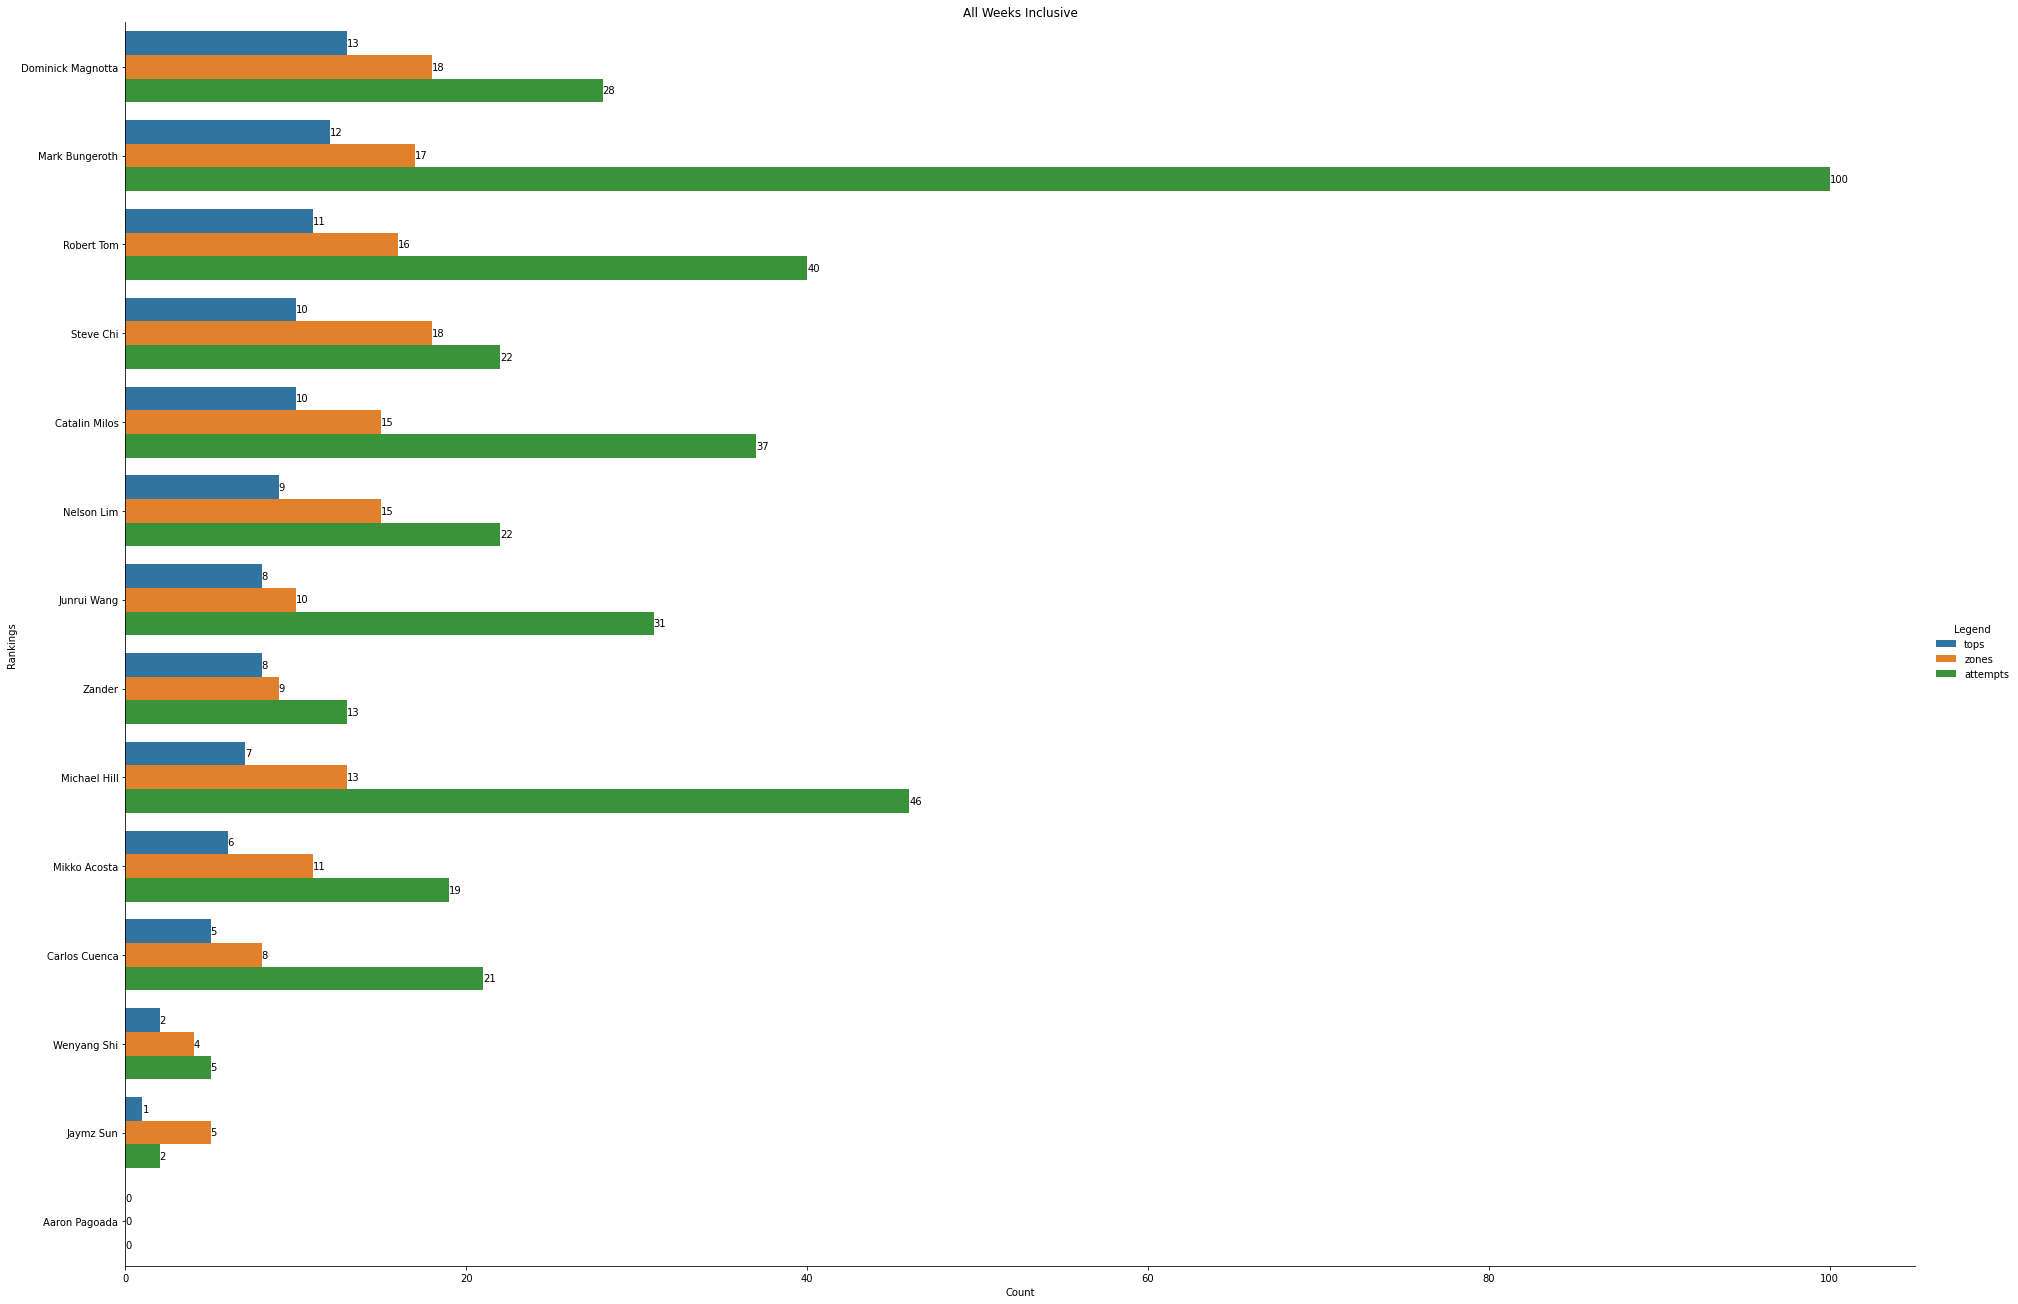

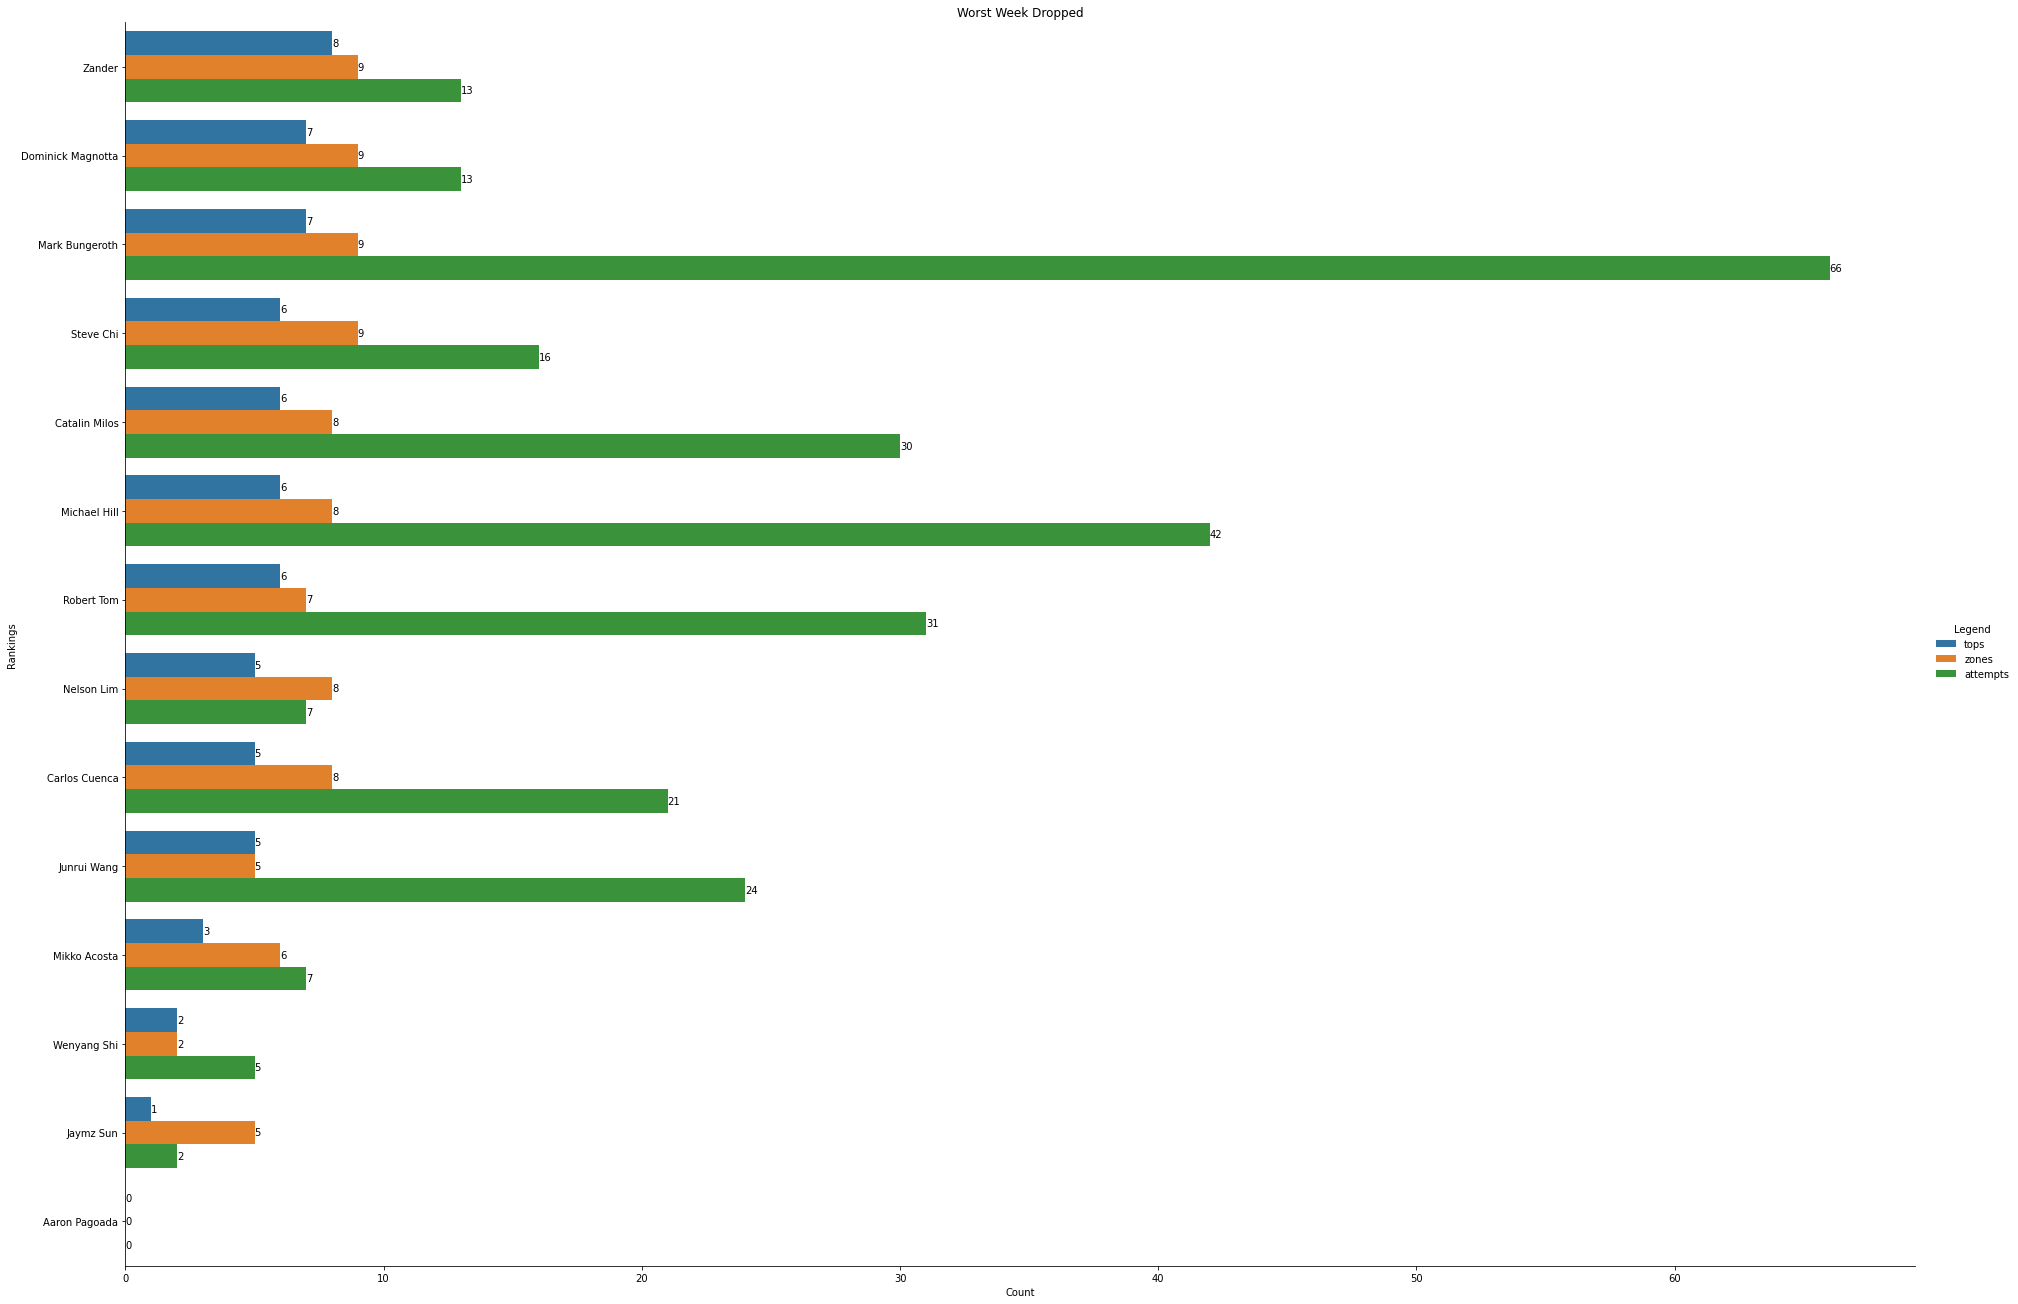

In [13]:
advanced_results_overall = prepare_results("advanced", "overall")
advanced_results_adjusted = prepare_results("advanced", "adjusted")

display(advanced_results_overall.style.set_caption('Ranking (All Weeks Inclusive)'))
display(advanced_results_adjusted.style.set_caption('Ranking (Worst Week Dropped)'))

advanced_results_overall = advanced_results_overall.drop(["rank", "worst_week"], axis=1)
advanced_results_adjusted = advanced_results_adjusted.drop(["rank", "worst_week"], axis=1)

plot_results(advanced_results_overall, "All Weeks Inclusive")
plot_results(advanced_results_adjusted, "Worst Week Dropped")


## Intermediate Results

,rank,tops,zones,attempts,worst_week
name,,,,,
Zach Hyer,1,17,19,63,"{""tops"": 7, ""zones"": 9, ""attempts"": 8}"
Charles Liou,2,16,19,23,"{""tops"": 8, ""zones"": 9, ""attempts"": 10}"
Chris Carmichael,3,16,19,34,"{""tops"": 8, ""zones"": 9, ""attempts"": 14}"
Daniel Chin,4,16,19,39,"{""tops"": 8, ""zones"": 9, ""attempts"": 15}"
John Eun,5,16,18,19,"{""tops"": 8, ""zones"": 9, ""attempts"": 10}"
Diego Medina,6,15,20,18,"{""tops"": 7, ""zones"": 10, ""attempts"": 8}"
Alex Abayev,7,15,19,24,"{""tops"": 6, ""zones"": 10, ""attempts"": 12}"
James Rudy,8,15,18,30,"{""tops"": 7, ""zones"": 9, ""attempts"": 14}"
Jade Chen,9,15,17,30,"{""tops"": 7, ""zones"": 8, ""attempts"": 11}"


,rank,tops,zones,attempts,worst_week
name,,,,,
Zach Hyer,1,10,10,55,"{""tops"": 7, ""zones"": 9, ""attempts"": 8}"
Alex Abayev,2,9,9,12,"{""tops"": 6, ""zones"": 10, ""attempts"": 12}"
Diego Medina,3,8,10,10,"{""tops"": 7, ""zones"": 10, ""attempts"": 8}"
Charles Liou,4,8,10,13,"{""tops"": 8, ""zones"": 9, ""attempts"": 10}"
Lindsay Matheos,5,8,10,14,"{""tops"": 4, ""zones"": 9, ""attempts"": 4}"
Chris Carmichael,6,8,10,20,"{""tops"": 8, ""zones"": 9, ""attempts"": 14}"
Daniel Chin,7,8,10,24,"{""tops"": 8, ""zones"": 9, ""attempts"": 15}"
John Eun,8,8,9,9,"{""tops"": 8, ""zones"": 9, ""attempts"": 10}"
Colin Konishi,9,8,9,11,"{""tops"": 0, ""zones"": 0, ""attempts"": 0}"


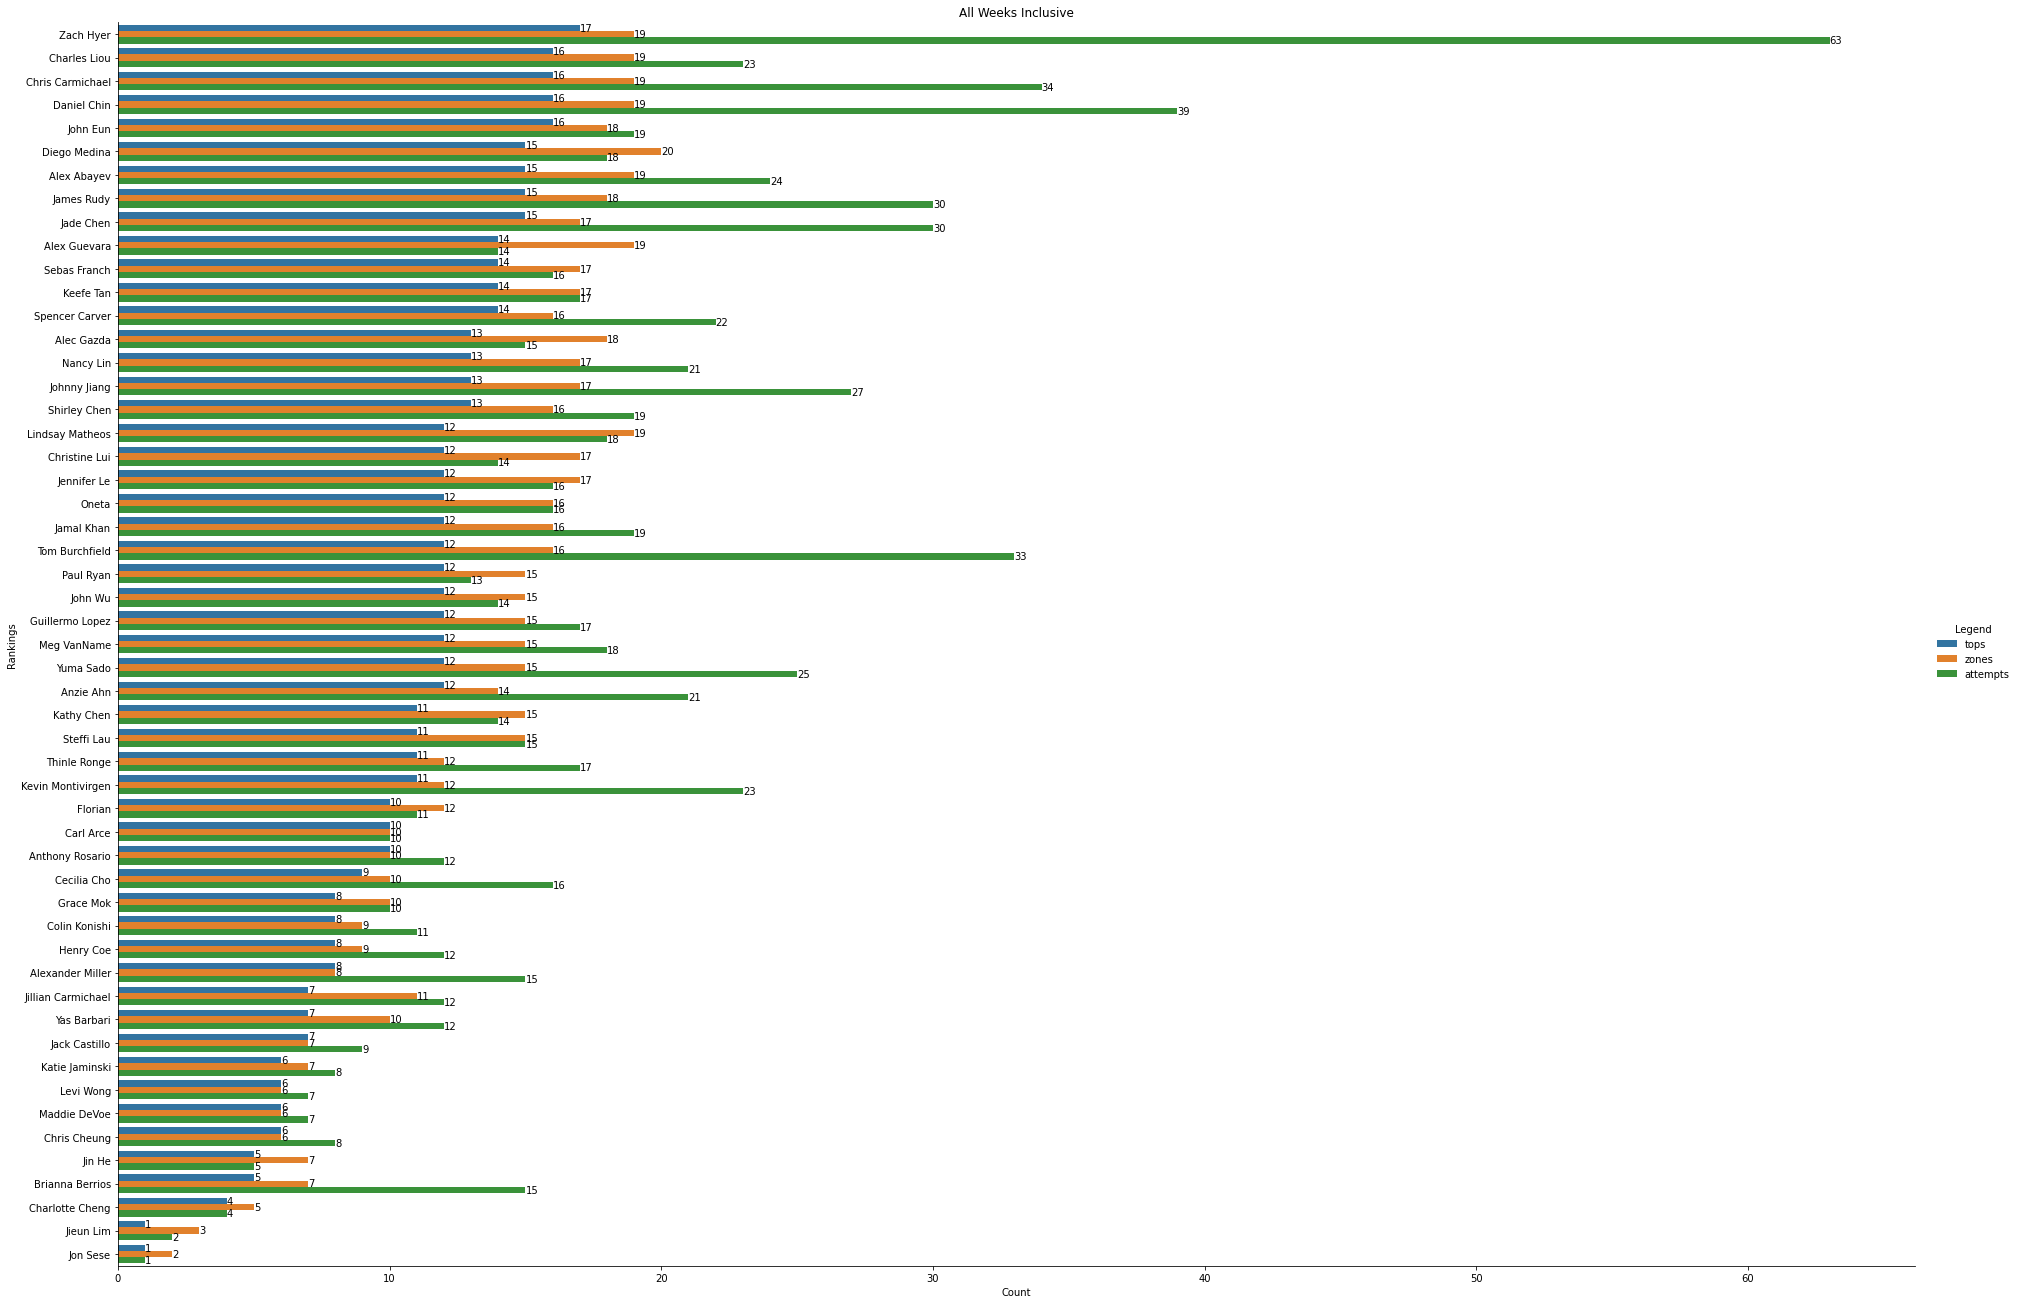

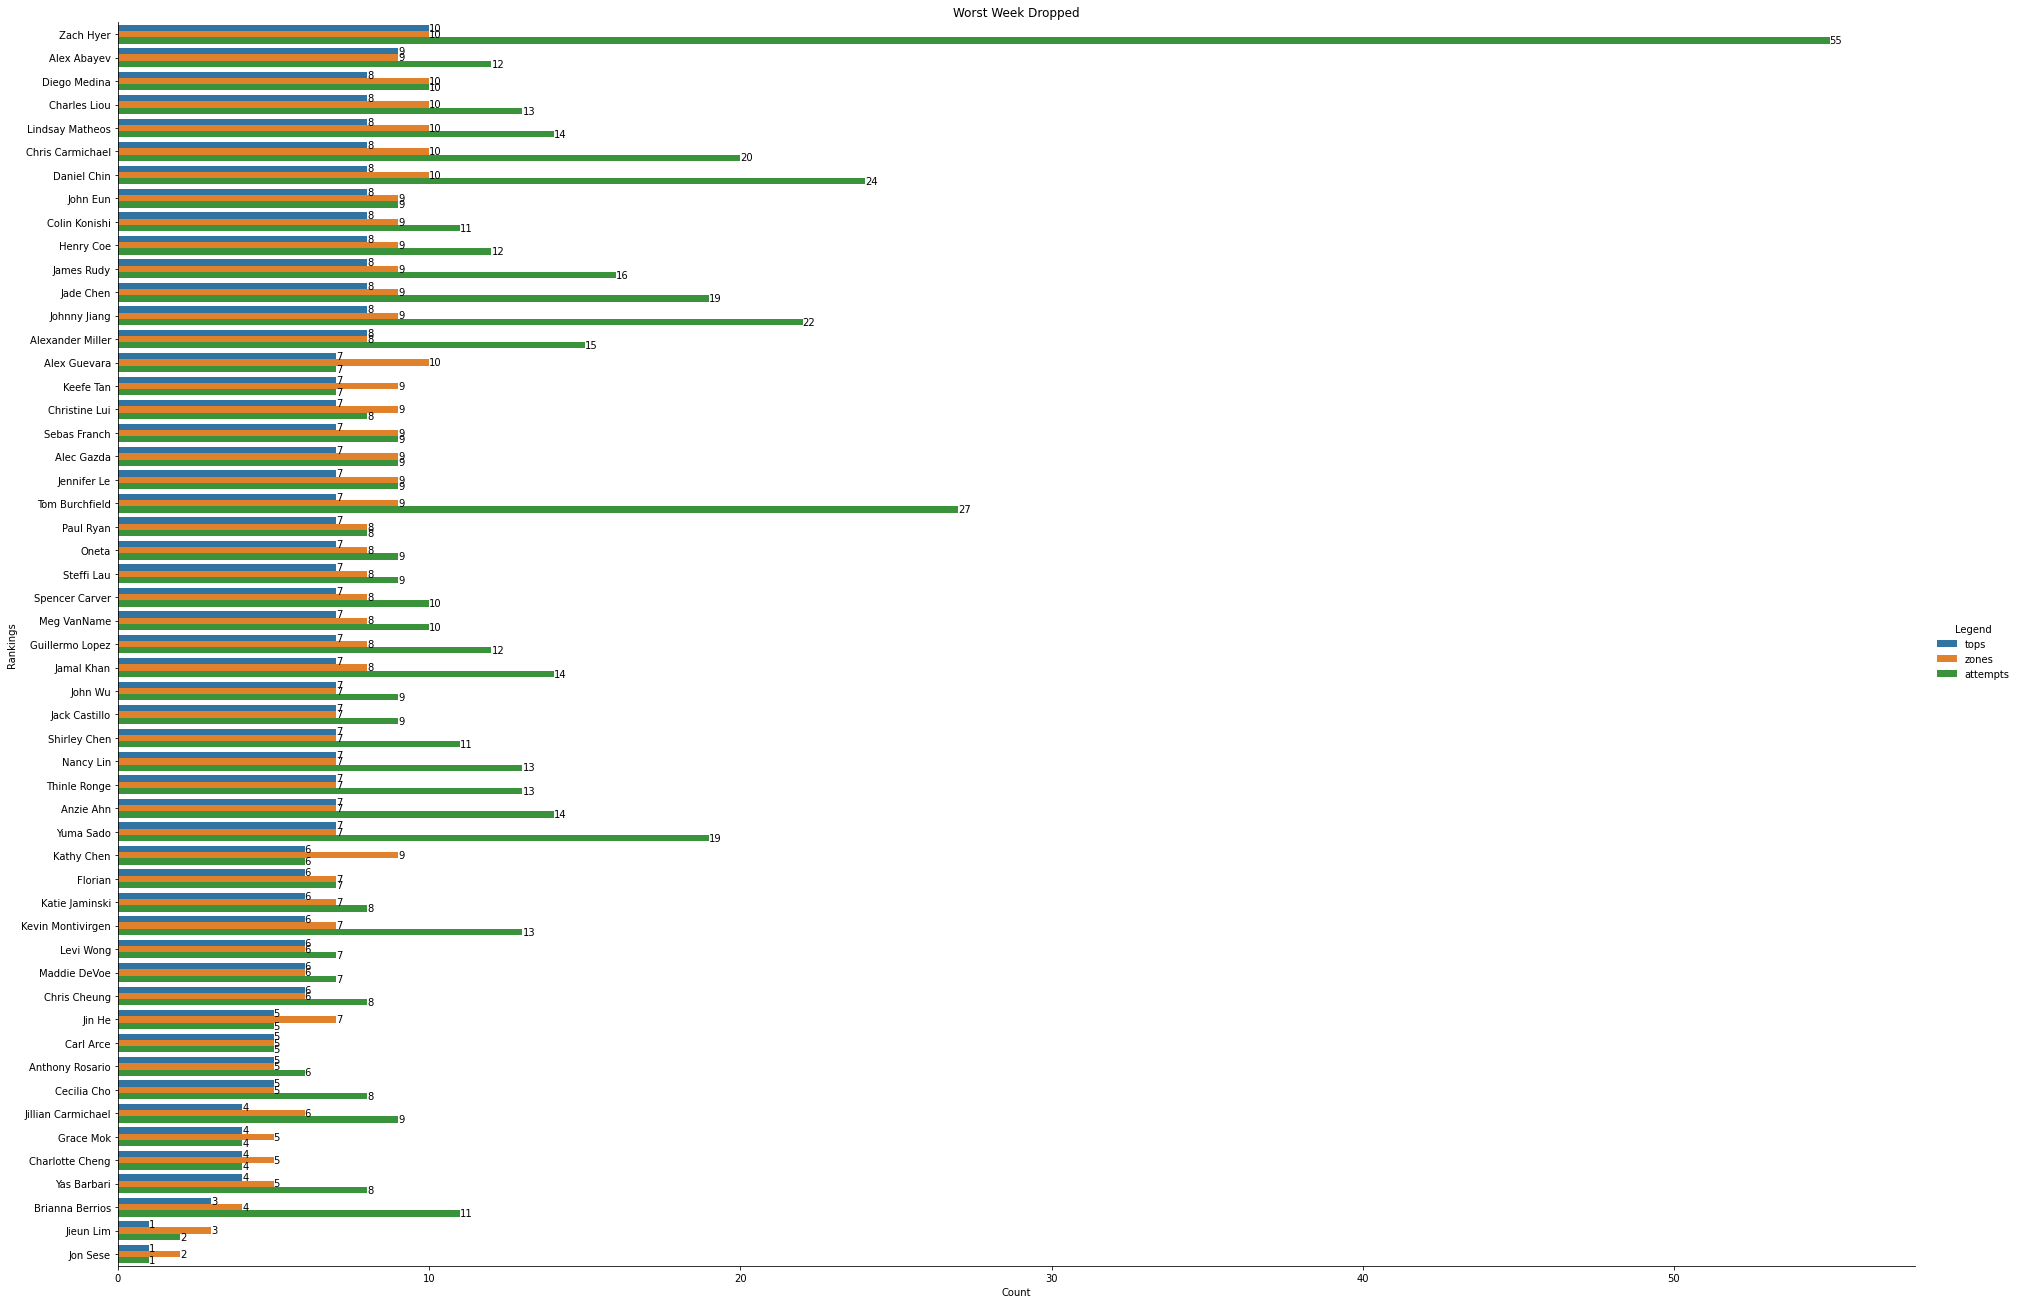

In [14]:
intermediate_results_overall = prepare_results("intermediate", "overall")
intermediate_results_adjusted = prepare_results("intermediate", "adjusted")

display(intermediate_results_overall.style.set_caption('Ranking (All Weeks Inclusive)'))
display(intermediate_results_adjusted.style.set_caption('Ranking (Worst Week Dropped)'))

intermediate_results_overall = intermediate_results_overall.drop(["rank", "worst_week"], axis=1)
intermediate_results_adjusted = intermediate_results_adjusted.drop(["rank", "worst_week"], axis=1)

plot_results(intermediate_results_overall, "All Weeks Inclusive")
plot_results(intermediate_results_adjusted, "Worst Week Dropped")

## Recreational Results

,rank,tops,zones,attempts,worst_week
name,,,,,
Tyler Beckinham,1,10,10,15,"{""tops"": 5, ""zones"": 5, ""attempts"": 10}"
Kate Polinsky,2,8,10,8,"{""tops"": 3, ""zones"": 5, ""attempts"": 3}"
Ava Oertle,3,7,8,7,"{""tops"": 3, ""zones"": 3, ""attempts"": 3}"
Alyssa Macaluso,4,7,8,9,"{""tops"": 3, ""zones"": 3, ""attempts"": 4}"
Armel Dogruluk,5,6,8,7,"{""tops"": 2, ""zones"": 3, ""attempts"": 2}"
Nicola de Prisco,6,6,8,7,"{""tops"": 3, ""zones"": 4, ""attempts"": 4}"
Amalia Aquino,7,5,9,8,"{""tops"": 2, ""zones"": 4, ""attempts"": 2}"
Riley Synan,8,5,7,9,"{""tops"": 2, ""zones"": 3, ""attempts"": 6}"
Sadmanul Islam,9,5,6,11,"{""tops"": 2, ""zones"": 2, ""attempts"": 6}"


,rank,tops,zones,attempts,worst_week
name,,,,,
Tyler Beckinham,1,5,5,5,"{""tops"": 5, ""zones"": 5, ""attempts"": 10}"
Kate Polinsky,2,5,5,5,"{""tops"": 3, ""zones"": 5, ""attempts"": 3}"
Ava Oertle,3,4,5,4,"{""tops"": 3, ""zones"": 3, ""attempts"": 3}"
Alyssa Macaluso,4,4,5,5,"{""tops"": 3, ""zones"": 3, ""attempts"": 4}"
Armel Dogruluk,5,4,5,5,"{""tops"": 2, ""zones"": 3, ""attempts"": 2}"
Amalia Aquino,6,3,5,6,"{""tops"": 2, ""zones"": 4, ""attempts"": 2}"
Nicola de Prisco,7,3,4,3,"{""tops"": 3, ""zones"": 4, ""attempts"": 4}"
Riley Synan,8,3,4,3,"{""tops"": 2, ""zones"": 3, ""attempts"": 6}"
Sadmanul Islam,9,3,4,5,"{""tops"": 2, ""zones"": 2, ""attempts"": 6}"


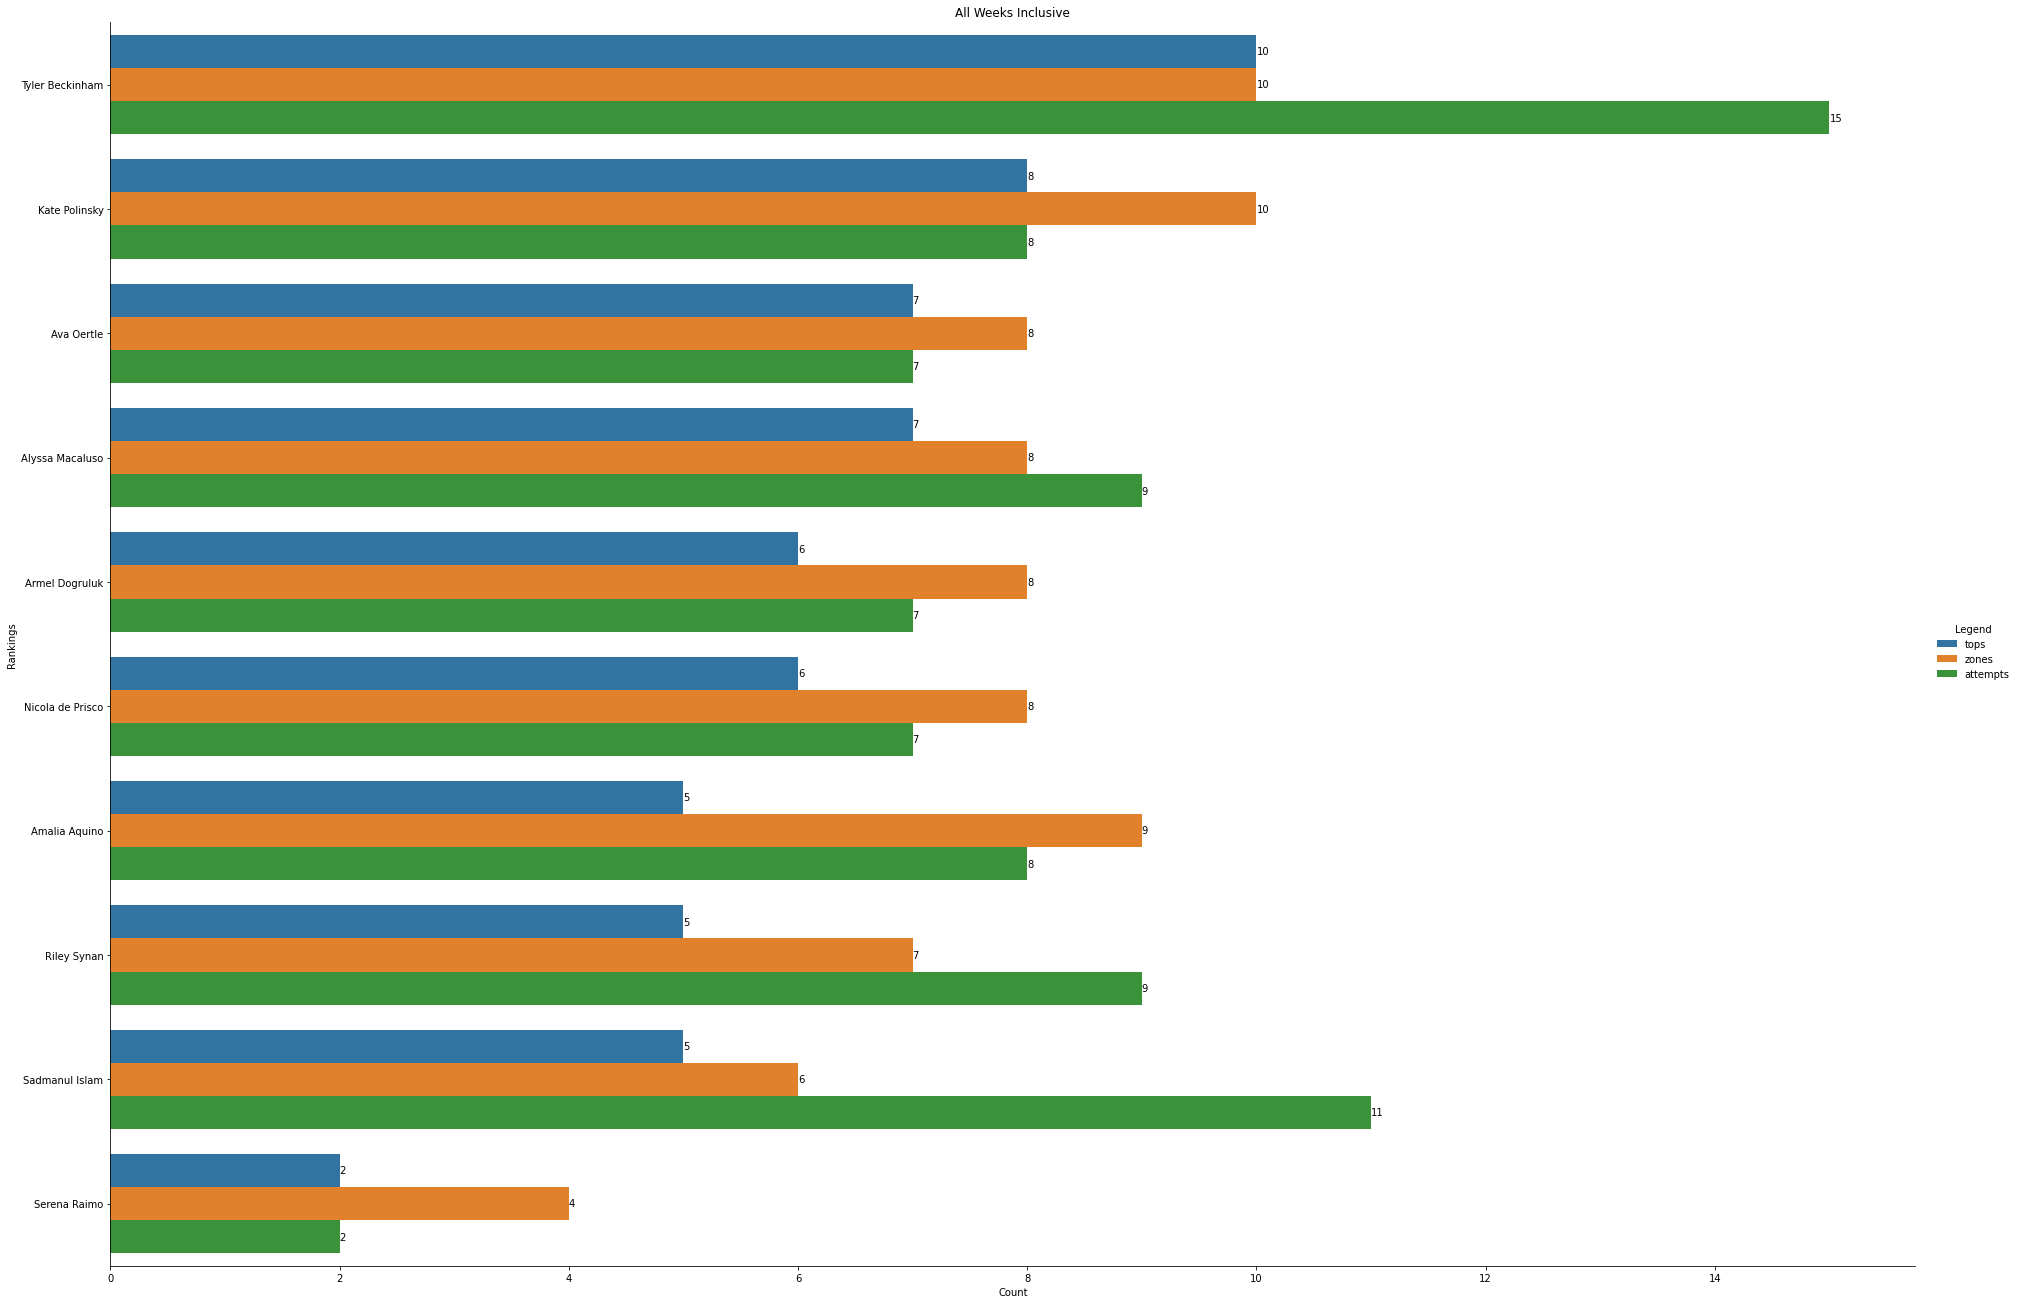

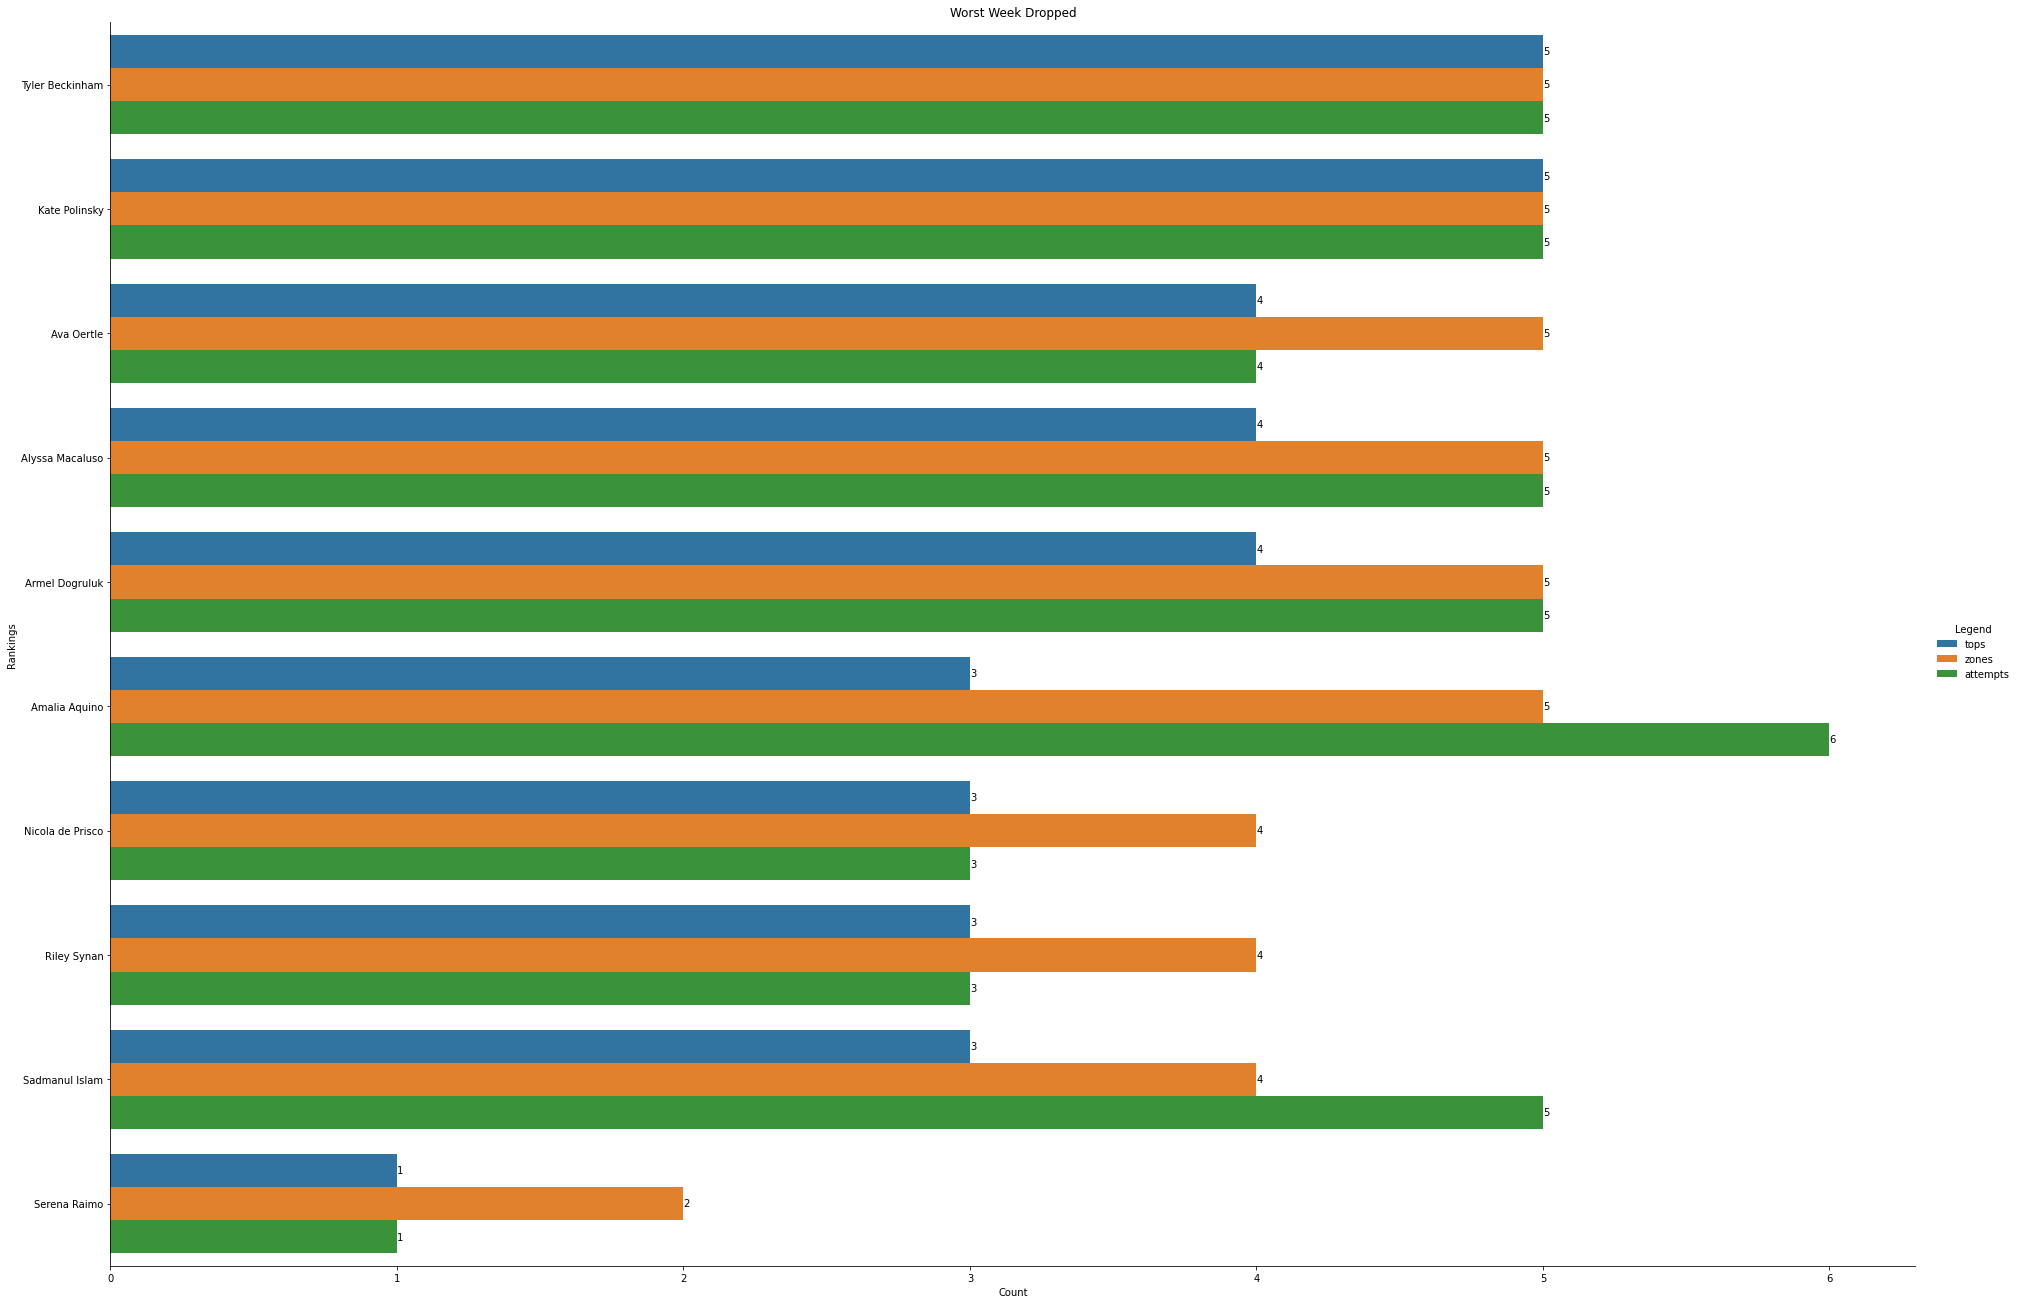

In [15]:
recreational_results_overall = prepare_results("recreational", "overall")
recreational_results_adjusted = prepare_results("recreational", "adjusted")

display(recreational_results_overall.style.set_caption('Ranking (All Weeks Inclusive)'))
display(recreational_results_adjusted.style.set_caption('Ranking (Worst Week Dropped)'))

recreational_results_overall = recreational_results_overall.drop(["rank", "worst_week"], axis=1)
recreational_results_adjusted = recreational_results_adjusted.drop(["rank", "worst_week"], axis=1)

plot_results(recreational_results_overall, "All Weeks Inclusive")
plot_results(recreational_results_adjusted, "Worst Week Dropped")